# Eigenvalue analysis of axisymmetric Mindlin plates by the pseudospectral method
J. Lee and W. W. Schultz 2004 [Eigenvalue analysis of Timoshenko beams and axisymmetric Mindlin plates by the pseudospectral method](https://www.sciencedirect.com/science/article/abs/pii/S0022460X03000476) (doi:10.1016/S0022-460X(03)00047-6)

**Limitations**
* The eigenvalues are found without the corresponding eigenmodes.
* Only the frequency of axisymmetric modes can be found.

In [1]:
import numpy as np
from numpy.polynomial import chebyshev as C # module
# from numpy.polynomial.chebyshev import Chebyshev as T : function
from scipy import linalg
import matplotlib.pyplot as plt
%matplotlib inline

visual_inspection_of_matrices = True

plt.rcParams['image.cmap'] = 'seismic'

In [2]:
def one_hot(n):
    onehot = np.zeros(n+1)
    onehot[n] = 1
    return onehot

def chebvander_deriv(z,deg_max,m=1):
    """
    [ T_0 T_1 ... T_{deg_max} ]
    nombre de lignes : len(z)
    nombre de colonnes : deg_max+1
    """
    return np.array([ C.Chebyshev(one_hot(i)).deriv(m)(z) for i in range(deg_max+1) ]).T

The equations of motion in terms of displacement are
$$\begin{array}{l}
\dfrac{\partial M_{r}}{\partial r}+\dfrac{1}{r}\left(M_{r}-M_{\theta}\right)-Q
=\rho I \dfrac{\partial^{2} \Psi}{\partial t^{2}} \\
\dfrac{\partial Q}{\partial r}+\dfrac{1}{r} Q
=\rho h \dfrac{\partial^{2} W}{\partial t^{2}}
\end{array}$$

With normalized $z=r/R$, $\psi(z)$ and $w(z)$ are
$$\begin{array}{l}
\dfrac{1}{R^{2}} \psi^{\prime \prime}+\dfrac{1}{z R^{2}} \psi^{\prime}-\left(\dfrac{1}{z^{2} R^{2}}+\dfrac{\kappa^{2} G h}{D}\right) \psi-\dfrac{\kappa^{2} G h}{R D} w^{\prime}=-\omega^{2} \dfrac{\rho I}{D} \psi \\
\dfrac{1}{R} \psi^{\prime}+\dfrac{1}{z R} \psi+\dfrac{1}{R^{2}} w^{\prime \prime}+\dfrac{1}{z R^{2}} w^{\prime}=-\omega^{2} \dfrac{\rho}{\kappa^{2} G} w
\end{array}$$

Series expansion of the exact solutions (partial sums):
$$\begin{array}{l}
\displaystyle \psi(z) \approx \tilde{\psi}(z)=\sum_{n=1}^{N+1} a_{n} T_{2 n-1}(z) \\
\displaystyle w(z) \approx \tilde{w}(z)=\sum_{n=1}^{N+1} b_{n} T_{2 n-2}(z)
\end{array}
$$
Note: the number of collocation points is less than that of expansion terms in (Timoshenko's) by 1 because the conditions at z=0 have already been considered.

In [3]:
# Material and geometrical parameters
E = 2.5e9 # Pa (Young's modulus)
nu = 0.3 #- (Poisson's ratio)
rho = 2500 # kg/m³ ≈ 2.2 kg/m² ÷ (2τ)
R = 1.5 # m (radius)
h = 0.25*R#10e-2 # m (plate thickness)
G = E/2/(1+nu) # shear modulus
D = E*h**3/12/(1-nu**2) # flexural rigidity
I = h**3/12 # integral of y² over the thickness
kappa = np.sqrt(np.pi**2/12) # shear correction factor
# kappa = np.sqrt(5/6) # to retrieve the results of Narita 2022

# Pick coefficients according to the problem we want to solve
ratio_raideurs = kappa**2*G*h/D
coeff_inertie_psi = rho*I/D
coeff_inertie_w = rho/kappa**2/G
CL_appui_Tp = 1
CL_appui_T = nu

# Numerical parameters
Nz = 35 # the actual "N" of the paper (number of collocation points)
Nd = 1 # extra expansion terms compared to the number of collocation points (keep it to 1!)
Nc = Nz + Nd # total number of unknown coefficients a_i (or b_i)

# ↓ Change boundary type here ("C" or "S") ↓
boundary_condition = "S"

The roots of $T_n$ are $x_i = \cos \dfrac{\pi(2i+1)}{2n}$.

The roots of $T_{n-1}$ are $x_i = \cos \dfrac{\pi(2i-1)}{2n}$.

For the Mindlin plate, the collocation points are
$$z_i = \cos \left( \dfrac{\pi ( 2 i - 1 ) }{ 4 N } \right) \qquad i = 1, \dots , N$$
(they only span half of the interval $[-1,1]$, that is, $]0,1]$)

In [4]:
# We take less collocation points than expansion terms to allow something that looks like "condensation"
z = np.cos(np.pi*(2*np.arange(1,Nz+1) - 1)/4/Nz) # C.chebpts1(2*N) where >0
Z = z[:,np.newaxis] #np.tile(z, (Nz, 1)).T
# C.chebvander(z, Nc) # expansion terms T_0 ... T_{N+1}

In [5]:
# DEBUGGING
# Check that my custom-made functions give the same result as list comprehension with chebder
assert np.allclose( np.array([ C.Chebyshev(one_hot(i))(z) for i in range(Nc+1) ]).T , C.chebvander(z,Nc) )
assert np.allclose( np.array([ C.Chebyshev(one_hot(i)).deriv(1)(z) for i in range(Nc+1) ]).T , chebvander_deriv(z,Nc,m=1) )
assert np.allclose( np.array([ C.Chebyshev(one_hot(i)).deriv(2)(z) for i in range(Nc+1) ]).T , chebvander_deriv(z,Nc,m=2) )

$$
\begin{gathered}
\sum_{n=1}^{N+1} a_{n}\left\{\frac{1}{R^{2}} T_{2 n-1}^{\prime \prime}\left(z_{i}\right)+\frac{1}{z_{i} R^{2}} T_{2 n-1}^{\prime}\left(z_{i}\right)-\left(\frac{1}{z_{i}^{2} R^{2}}+\frac{\kappa^{2} G h}{D}\right) T_{2 n-1}\left(z_{i}\right)\right\}
-
\frac{\kappa^{2} G h}{R D} \sum_{n=1}^{N+1} b_{n} T_{2 n-2}^{\prime}\left(z_{i}\right)=-\omega^{2} \frac{\rho I}{D} \sum_{n=1}^{N+1} a_{n} T_{2 n-1}\left(z_{i}\right)
\\
\sum_{n=1}^{N+1} a_{n}\left\{\frac{1}{R} T_{2 n-1}^{\prime}\left(z_{i}\right)+\frac{1}{z_{i} R} T_{2 n-1}\left(z_{i}\right)\right\}
+
\sum_{n=1}^{N+1} b_{n}\left\{\frac{1}{R^{2}} T_{2 n-2}^{\prime \prime}\left(z_{i}\right)+\frac{1}{z_{i} R^{2}} T_{2 n-2}^{\prime}\left(z_{i}\right)\right\}=-\omega^{2} \frac{\rho}{\kappa^{2} G} \sum_{n=1}^{N+1} b_{n} T_{2 n-2}\left(z_{i}\right), \quad i=1, \ldots, N
\end{gathered}
$$

$$
[\mathbf{H}]\{\mathbf{d}\}+\left[\mathbf{H}^{\dagger}\right]\left\{\mathbf{d}^{\dagger}\right\}=\omega^{2}\left([\mathbf{S}]\{\mathbf{d}\}+\left[\mathbf{S}^{\dagger}\right]\left\{\mathbf{d}^{\dagger}\right\}\right)
$$

In [6]:
# Store Chebyshev values and derivatives
T   = C.chebvander(z, 2*Nc)
Tp  = chebvander_deriv(z, 2*Nc, m=1)
Tpp = chebvander_deriv(z, 2*Nc, m=2)

# Calcul de H (raideur)
H1a = Tpp[:,1:2*Nc-1:2]/R**2 + Tp[:,1:2*Nc-1:2]/Z/R**2 - (1/Z**2/R**2 + ratio_raideurs)*T[:,1:2*Nc-1:2]
H1b = -ratio_raideurs/R * Tp[:,0:2*Nc-2:2]
H2a = Tp[:,1:2*Nc-1:2]/R + T[:,1:2*Nc-1:2]/Z/R
H2b = Tpp[:,0:2*Nc-2:2]/R**2 + Tp[:,0:2*Nc-2:2]/Z/R**2
# # Calcul de S (inertie)
S1a = -coeff_inertie_psi * T[:,1:2*Nc-1:2]
S1b = np.zeros((Nz,Nz))
S2a = np.zeros((Nz,Nz))
S2b = -coeff_inertie_w * T[:,0:2*Nc-2:2]

H = np.block([[ H1a[:,:Nz] , H1b[:,:Nz] ],
              [ H2a[:,:Nz] , H2b[:,:Nz] ]])
# Note : H1a[:,Nz:] ne marchait pas (tableau vide)
Hdag = np.block([[ H1a[:,-Nd:] , H1b[:,-Nd:] ],
                 [ H2a[:,-Nd:] , H2b[:,-Nd:] ]])
S = np.block([[ S1a[:,:Nz] , S1b[:,:Nz] ],
              [ S2a[:,:Nz] , S2b[:,:Nz] ]])
Sdag = np.block([[ S1a[:,-Nd:] , S1b[:,-Nd:] ],
                 [ S2a[:,-Nd:] , S2b[:,-Nd:] ]])

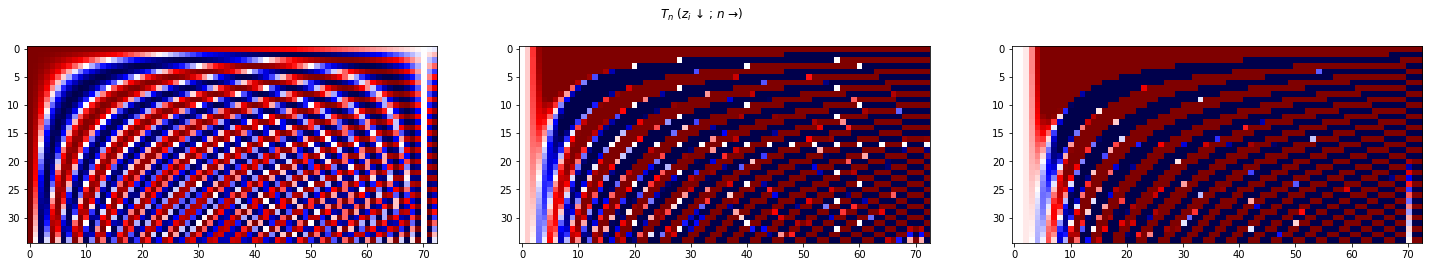

In [7]:
if visual_inspection_of_matrices:
    # Inspect the Chebyshev polynomials
    # T_n(z_i)
    plt.rcParams["figure.figsize"] = [25,4]
    fig, ax = plt.subplots(1,3)
    ax[0].imshow(T,vmin=-1,vmax=1)
    ax[1].imshow(Tp,vmin=-1e1,vmax=1e1)
    ax[2].imshow(Tpp,vmin=-1e2,vmax=1e2)
    plt.suptitle("$T_n$ ($z_i$ ↓ ; $n$ →)")
    # plt.savefig("Chebyshev.pdf",transparent=True)
    plt.show()

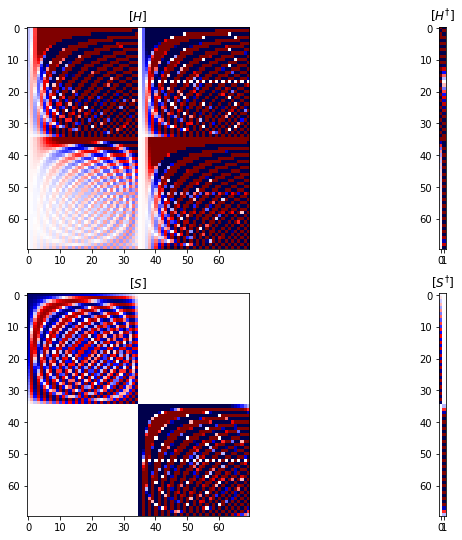

In [8]:
if visual_inspection_of_matrices:
    # Inspect H, Hdag, S, Sdag
    plt.rcParams["figure.figsize"] = [10,9]
    fig, ax = plt.subplots(2,2)
    ax[0,0].imshow(H, vmin=-2e2, vmax=2e2)
    ax[0,0].set_title("$[H]$")
    ax[0,1].imshow(Hdag, vmin=-1e3, vmax=1e3)
    ax[0,1].set_title("$[H^\dag]$")
    ax[1,0].imshow(S, vmin=-1e-6, vmax=1e-6)
    ax[1,0].set_title("$[S]$")
    ax[1,1].imshow(Sdag, vmin=-1e-6, vmax=1e-6)
    ax[1,1].set_title("$[S^\dag]$")
    plt.show()

Boundary conditions
$$
[\mathbf{U}]\{\mathbf{d}\}+[\mathbf{V}]\left\{\mathbf{d}^{\dagger}\right\}=\{\mathbf{0}\},
$$

In [9]:
# Recompute Chebyshev polynomials at z=1
# Note: Nd will always equal 1.
T   = C.chebvander(np.ones((Nd,)), 2*Nc) # all Chebyshev polynomials equal 1 at z=1...
Tp  = chebvander_deriv(np.ones((Nd,)), 2*Nc, m=1)
Tpp = chebvander_deriv(np.ones((Nd,)), 2*Nc, m=2)

if boundary_condition == "C":
    Ua = T[:,1:2*Nc-1:2] # ψ(z=1)=0
    Ub = T[:,0:2*Nc-2:2] # w(z=1)=0
elif boundary_condition == "S":
    Ua = CL_appui_Tp*Tp[:,1:2*Nc-1:2] + CL_appui_T*T[:,1:2*Nc-1:2] # ψ
    Ub = T[:,0:2*Nc-2:2] # w(z=1)=0
else:
    raise Exception("Unexpected boundary type")

U = np.block([[        Ua         , np.zeros((Nd,Nz)) ],
              [ np.zeros((Nd,Nz)) ,        Ub         ]])
V = np.block([[    Ua[:,-Nd:]     ,  np.zeros((Nd,Nd)) ],
              [ np.zeros((Nd,Nd)) ,   Ub[:,-Nd:]       ]])

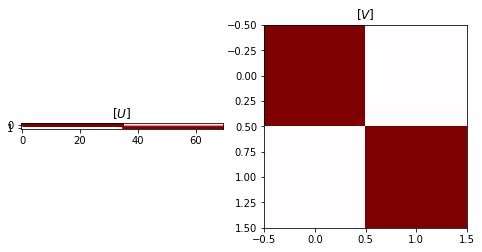

In [10]:
if visual_inspection_of_matrices:
    # Inspect U and V
    plt.rcParams["figure.figsize"] = [8,5]
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(U, vmin=-1, vmax=1)
    ax[0].set_title("$[U]$")
    ax[1].imshow(V, vmin=-1, vmax=1)
    ax[1].set_title("$[V]$")
    plt.show()

Eliminate $\{\mathbf{d}^{\dagger}\}$
$$
\left\{\mathbf{d}^{\dagger}\right\}=-[\mathbf{V}]^{-1}[\mathbf{U}]\{\mathbf{d}\},
$$

$$
\left([\mathbf{H}]-\left[\mathbf{H}^{\dagger}\right][\mathbf{V}]^{-1}[\mathbf{U}]\right)\{\mathbf{d}\}=\omega^{2}\left([\mathbf{S}]-\left[\mathbf{S}^{\dagger}\right][\mathbf{V}]^{-1}[\mathbf{U}]\right)\{\mathbf{d}\}
$$

> Note: trying to have `Nd` > 1 will fail here for clamped boundary conditions since $[V]$ will always be singular:
$$
[V] =
\begin{bmatrix}
1 & 1 & 0 & 0 \\
1 & 1 & 0 & 0 \\
0 & 0 & 1 & 1 \\
0 & 0 & 1 & 1 
\end{bmatrix}
$$

---
# Solving

0.0


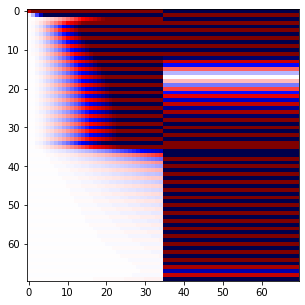

In [11]:
if visual_inspection_of_matrices:
    # Inspect [H] [V]^-1 U
    print( np.linalg.det(Hdag @ np.linalg.inv(V) @ U) )
    plt.imshow( Hdag @ ( np.linalg.inv(V) @ U ), vmin=-1e3,vmax=1e3 )

In [12]:
A = H - Hdag @ np.linalg.inv(V) @ U
B = S - Sdag @ np.linalg.inv(V) @ U
ω2 = linalg.eigvals( A , B )
real_ω2 = ω2.real[abs(ω2.imag)<1e-5] # filter out imaginary eigvals
ω = np.sqrt(real_ω2)
ω.sort()

show_only_N_firsts = 15
print(f"Eigenfrequencies ({boundary_condition})")
for i in range(show_only_N_firsts):
    print(f"Mode {i+1:3.0f} : {ω[i]:7.0f} rad/s = {ω[i]/2/np.pi:7.0f} Hz")
if len(ω) > show_only_N_firsts:
    print(f"* Only {show_only_N_firsts} modes are displayed ({len(ω)} were computed).")

Eigenfrequencies (S)
Mode   1 :     237 rad/s =      38 Hz
Mode   2 :    1173 rad/s =     187 Hz
Mode   3 :    2359 rad/s =     375 Hz
Mode   4 :    3611 rad/s =     575 Hz
Mode   5 :    4873 rad/s =     775 Hz
Mode   6 :    5461 rad/s =     869 Hz
Mode   7 :    6128 rad/s =     975 Hz
Mode   8 :    6640 rad/s =    1057 Hz
Mode   9 :    7372 rad/s =    1173 Hz
Mode  10 :    8236 rad/s =    1311 Hz
Mode  11 :    8607 rad/s =    1370 Hz
Mode  12 :    9832 rad/s =    1565 Hz
Mode  13 :   10036 rad/s =    1597 Hz
Mode  14 :   10206 rad/s =    1624 Hz
Mode  15 :   11051 rad/s =    1759 Hz
* Only 15 modes are displayed (55 were computed).


Non-dimensionalized frequency parameter
$$\lambda_i^2
= \omega_i \dfrac{R^2}{\sqrt{D/\rho h}}
= \omega_i R^2 \sqrt{\dfrac{\rho h}{D}}$$

In [13]:
# Non-dimensionalized frequency parameter
λi2 = ω*R**2*np.sqrt(rho*h/D)
λi2.sort()

print("Non-dimensionalized frequency parameter λ²")
for i in range(show_only_N_firsts):
    print(f"Mode {i+1:3.0f} : {λi2[i]:9.4f}")
if len(λi2) > show_only_N_firsts:
    print(f"* Only {show_only_N_firsts} modes are displayed ({len(λi2)} were computed).")

Non-dimensionalized frequency parameter λ²
Mode   1 :    4.6963
Mode   2 :   23.2541
Mode   3 :   46.7745
Mode   4 :   71.6032
Mode   5 :   96.6090
Mode   6 :  108.2739
Mode   7 :  121.4989
Mode   8 :  131.6496
Mode   9 :  146.1721
Mode  10 :  163.3039
Mode  11 :  170.6466
Mode  12 :  194.9427
Mode  13 :  198.9838
Mode  14 :  202.3659
Mode  15 :  219.1061
* Only 15 modes are displayed (55 were computed).


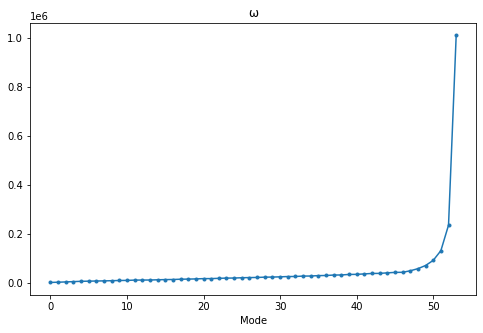

In [14]:
plt.plot(ω, ".-")
plt.title("ω")
plt.xlabel("Mode");

---
# Comparison with Temel 2020
[A unified solution for the vibration analysis of two-directional functionally graded axisymmetric Mindlin–Reissner plates with variable thickness](https://www.sciencedirect.com/science/article/abs/pii/S0020740319329364)

$$\Omega = \sqrt{ \dfrac{ \rho h r^4}{D} \omega^2 }
= \omega \sqrt{\dfrac{ \rho h}{D}} r^2$$

Temel et al. say that $D = \dfrac{E h^3}{12(1-\color{red}\nu)}$ but it's a typo (the discrepancy is bigger without the ²).

In [15]:
Ω_Temel = np.sqrt(rho*h*R**4/D * real_ω2) # Same as Lee.
Ω_Temel.sort()
for i in range(15):
    print(f"{Ω_Temel[i]:7.4f}")

 4.6963
23.2541
46.7745
71.6032
96.6090
108.2739
121.4989
131.6496
146.1721
163.3039
170.6466
194.9427
198.9838
202.3659
219.1061


Reminder of Lee's results:
```python
## C
# δ = 0.001 Ω_Temel = 10.233 (Nz=35)
# δ = 0.005 Ω_Temel = 10.215 (Nz=35)
# δ = 0.15  Ω_Temel =  9.6286 (Nz=35)
# δ = 0.25  Ω_Temel =  8.8068 (Nz=35 and Nz=65)
## S
# δ = 0.001 Ω_Temel = 4.5387 (Nz=35) or 3.0323 (Nz=65)
# δ = 0.005 Ω_Temel = 4.9353 (Nz=35) or 4.9350 (Nz=65)
# δ = 0.15  Ω_Temel = 4.8439 (Nz=35)
# δ = 0.25  Ω_Temel = 4.6963 (Nz=35)
```

**Remarks**
* My code agrees with Lee2004 in every case (δ=0.05, δ=0.01, δ=0.1, δ=0.25).
* [Temel2020](https://www.sciencedirect.com/science/article/abs/pii/S0020740319329364) probably meant δ = 0.005 instead of δ = 0.001 in their Table 2.
* I am bothered by the convergence problem with Nz for Simple Support when δ = 0.001.

---
# Comparison with Narita 2002 (Table 2)
[Vibration Analysis of Shear-deformable Circular and Elliptical Laminated Composite Plates](https://www.jstage.jst.go.jp/article/jsmec/45/1/45_1_113/_article/-char/ja/)

They define $a = R/2$ so I use $\Omega = \lambda_i^2 = \omega_i (\color{red}2R)^2 \sqrt{\dfrac{\rho h}{D}}$.
Also they say κ=5/6 so in my code I have to write `kappa=np.sqrt(5/6)`
* Clamped at `a/h = 10`: I retrieved their modes `(n=0,s=0)` at Ω=λ²=39.5 (they get 37) and `(n=0,s=1)` (I get 144.1 instead of their 120.8). I don't see any of the others: `(1,0)`, `(2,0)`, `(3,0)`.
* Clamped at `a/h = 100`: for `(n=0,s=1)` I get 158.9 instead of their 158.5. Clearly I only found the axisymmetric modes where `n=0`.

In [16]:
# Narita 2002
ω*(2*R)**2*np.sqrt(rho*h/D)

array([1.87853279e+01, 9.30165088e+01, 1.87098050e+02, 2.86412995e+02,
       3.86435909e+02, 4.33095602e+02, 4.85995405e+02, 5.26598309e+02,
       5.84688425e+02, 6.53215625e+02, 6.82586366e+02, 7.79770661e+02,
       7.95935003e+02, 8.09463688e+02, 8.76424472e+02, 9.47667157e+02,
       9.72605765e+02, 1.06839782e+03, 1.10511000e+03, 1.16388558e+03,
       1.25910725e+03, 1.26637969e+03, 1.35412612e+03, 1.43032711e+03,
       1.44896434e+03, 1.54369802e+03, 1.59623589e+03, 1.63873574e+03,
       1.73578034e+03, 1.76359868e+03, 1.83889592e+03, 1.93200049e+03,
       1.95289886e+03, 2.08327619e+03, 2.10148828e+03, 2.23430789e+03,
       2.27171776e+03, 2.41968998e+03, 2.44220015e+03, 2.61234537e+03,
       2.64327246e+03, 2.78440261e+03, 2.93631536e+03, 2.95445531e+03,
       3.12909991e+03, 3.27986159e+03, 3.30563482e+03, 3.80018949e+03,
       4.48687953e+03, 5.51110101e+03, 7.17510415e+03, 1.03244735e+04,
       1.85988522e+04, 8.01464135e+04,            inf])

---
# Comparison with Wang 1994 (Table 3)
[Natural Frequencies Formula for Simply Supported Mindlin Plates](https://asmedigitalcollection.asme.org/vibrationacoustics/article-abstract/116/4/536/441527/Natural-Frequencies-Formula-for-Simply-Supported)

Typo in the caption: $(\omega_M b^{\color{red}2}) \sqrt{\rho h/D}$
* I only retrieved their modes 1, 6 and 12.